In [20]:
# Uncomment the following lines if you need to install these packages
# !pip install torch torchvision torchaudio
# !pip install scikit-learn
# !pip install seaborn
# !pip install tqdm
# !pip install matplotlib

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import TensorDataset, DataLoader
from tqdm import trange
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting


## Download Datasets


In [21]:
def download_datasets(N_values=[18, 24], base_url="https://github.com/guyuxuan9/MML_coursework/raw/refs/heads/main/Datasets/"):
    for N in N_values:
        X_filename = f'kryptonite-{N}-X.npy'
        y_filename = f'kryptonite-{N}-y.npy'

        # Check and download X
        if not os.path.exists(X_filename):
            print(f"Downloading {X_filename}...")
            os.system(f"wget {base_url}{X_filename} -O {X_filename}")
        else:
            print(f"{X_filename} already exists. Skipping download.")

        # Check and download y
        if not os.path.exists(y_filename):
            print(f"Downloading {y_filename}...")
            os.system(f"wget {base_url}{y_filename} -O {y_filename}")
        else:
            print(f"{y_filename} already exists. Skipping download.")


## Preprocess Data

In [22]:
def prepare_data(N, test_size=0.2, random_state=42, batch_size=32):
    """
    Loads data, splits into training and test sets, scales features, and creates data loaders.

    Args:
        N (int): Dataset size (e.g., 18 or 24).
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random state for reproducibility.
        batch_size (int): Batch size for data loaders.

    Returns:
        train_loader (DataLoader): DataLoader for training data.
        test_loader (DataLoader): DataLoader for test data.
        input_dim (int): Number of input features.
    """
    X_filename = f'kryptonite-{N}-X.npy'
    y_filename = f'kryptonite-{N}-y.npy'

    # Load the data
    X = np.load(X_filename)
    y = np.load(y_filename)

    input_dim = X.shape[1]

    # Split the dataset into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Standardization (zero mean, unit variance)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert them into PyTorch tensors and move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # Create DataLoader for training and test datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, input_dim, scaler


## Functions for Model build + eval

In [23]:
def build_model(input_dim, first_layer_size=512, activation='gelu'):
    """
    Builds a binary classification neural network model.

    Args:
        input_dim (int): Number of input features (e.g., 18 or 24).
        first_layer_size (int): Number of neurons in the first hidden layer.
        activation (str): Activation function to use ('relu' or 'gelu').

    Returns:
        model (nn.Module): The constructed neural network model.
    """
    # Define activation function
    if activation.lower() == 'relu':
        activation_fn = nn.ReLU()
    elif activation.lower() == 'gelu':
        activation_fn = nn.GELU()
    else:
        raise ValueError("Unsupported activation function. Choose 'relu' or 'gelu'.")

    class BinaryClassifier(nn.Module):
        def __init__(self, input_dim, first_layer_size, activation_fn):
            super(BinaryClassifier, self).__init__()

            self.fc1 = nn.Linear(input_dim, first_layer_size)
            self.bn1 = nn.LayerNorm(first_layer_size)
            self.fc2 = nn.Linear(first_layer_size, 256)
            self.bn2 = nn.LayerNorm(256)
            self.fc3 = nn.Linear(256, 256)
            self.fc4 = nn.Linear(256, 256)
            self.fc5 = nn.Linear(256, 128)
            self.fc6 = nn.Linear(128, 1)  # Output layer

            self.activation = activation_fn
            self.sigmoid = nn.Sigmoid()

        def forward(self, x):
            x = self.activation(self.bn1(self.fc1(x)))
            x = self.activation(self.bn2(self.fc2(x)))
            x = self.activation(self.fc3(x))
            x = self.activation(self.fc4(x))
            x = self.activation(self.fc5(x))
            x = self.fc6(x)
            x = self.sigmoid(x)
            return x

    model = BinaryClassifier(input_dim, first_layer_size, activation_fn)
    return model



def evaluate_model(model, test_loader, criterion, device, model_name="model"):
    """
    Evaluates the model on the test set and prints metrics.

    Args:
        model (nn.Module): Trained neural network model.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (loss function): Loss function used during training.
        device (torch.device): Device to perform computations on.
        model_name (str): Name identifier for the model (used in plots).
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).cpu().numpy()
            all_probs.append(probs)
            all_preds.append(preds)
            all_labels.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    all_probs = np.concatenate(all_probs, axis=0)

    # Calculate final test accuracy
    final_test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Final Test Accuracy for {model_name}: {final_test_accuracy * 100:.2f}%")

    # Generate Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Classification Report
    report = classification_report(all_labels, all_preds, digits=4)
    print("Classification Report:")
    print(report)


def train_model(model, train_loader, test_loader, criterion, optimizer, device, epochs=50, model_save_path='best_model.pt', model_name="model"):
    """
    Trains the neural network model.

    Args:
        model (nn.Module): The neural network model.
        train_loader (DataLoader): DataLoader for the training data.
        test_loader (DataLoader): DataLoader for the test data.
        criterion (loss function): Loss function.
        optimizer (optimizer): Optimizer.
        device (torch.device): Device to perform computations on.
        epochs (int): Number of training epochs.
        model_save_path (str): Path to save the best model.
        model_name (str): Name identifier for the model.

    Returns:
        model (nn.Module): Trained model with best parameters.
        history (dict): Dictionary containing loss and accuracy history.
    """
    model.to(device)

    # Store loss and accuracy values for plotting
    history = {
        'train_losses': [],
        'test_losses': [],
        'train_accuracies': [],
        'test_accuracies': []
    }

    # Initialize a variable to track the best test loss
    best_test_loss = float('inf')

    for epoch in trange(epochs, desc=f"Training {model_name}"):
        model.train()
        running_loss = 0.0
        all_preds_train = []
        all_labels_train = []

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            all_preds_train.append((outputs > 0.5).cpu().numpy())
            all_labels_train.append(targets.cpu().numpy())

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        all_preds_train = np.concatenate(all_preds_train, axis=0)
        all_labels_train = np.concatenate(all_labels_train, axis=0)
        train_accuracy = accuracy_score(all_labels_train, all_preds_train)

        # Evaluate on test set
        model.eval()
        test_loss = 0.0
        all_preds_test = []
        all_labels_test = []

        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss += loss.item()
                all_preds_test.append((outputs > 0.5).cpu().numpy())
                all_labels_test.append(targets.cpu().numpy())

        test_loss = test_loss / len(test_loader)
        all_preds_test = np.concatenate(all_preds_test, axis=0)
        all_labels_test = np.concatenate(all_labels_test, axis=0)
        test_accuracy = accuracy_score(all_labels_test, all_preds_test)

        # Save history
        history['train_losses'].append(train_loss)
        history['test_losses'].append(test_loss)
        history['train_accuracies'].append(train_accuracy)
        history['test_accuracies'].append(test_accuracy)

        # Check if the current test loss is the best
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"New best model saved with test loss: {best_test_loss:.4f}")

        # Print progress every 10 epochs and first epoch
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch [{epoch+1}/{epochs}], "
                  f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}%, "
                  f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

    # Plotting the Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), history['train_losses'], label='Train Loss', color='blue', marker='o')
    plt.plot(range(1, epochs + 1), history['test_losses'], label='Test Loss', color='red', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Test Loss Curve for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the Accuracy Curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), [acc * 100 for acc in history['train_accuracies']], label='Train Accuracy', color='blue', marker='o')
    plt.plot(range(1, epochs + 1), [acc * 100 for acc in history['test_accuracies']], label='Test Accuracy', color='green', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Test Accuracy Curve for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history


## Visualise Model Perturbation and Weights

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange

def visualise_loss_perturbation(
    model,
    model_name,
    test_loader,
    criterion,
    layer_name,
    param_name,
    param_idx,
    delta_range,
    device,
    subset_size=100  # Number of samples to use from the test set
):
    """
    Visualises how the loss changes when perturbing a specific parameter.

    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (loss function): Loss function to compute loss.
        layer_name (str): Name of the layer containing the parameter.
        param_name (str): Name of the parameter ('weight' or 'bias').
        param_idx (tuple): Index of the parameter to perturb.
        delta_range (array-like): Range of perturbation values.
        device (torch.device): Device to perform computations on.
        subset_size (int): Number of samples from the test set to use for evaluation.
    """
    # Access the specified layer and parameter
    try:
        layer = dict([*model.named_modules()])[layer_name]
    except KeyError:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    try:
        param = getattr(layer, param_name)
    except AttributeError:
        raise ValueError(f"Parameter '{param_name}' not found in layer '{layer_name}'.")

    # Ensure that param_idx is a tuple for multi-dimensional parameters
    if isinstance(param_idx, int):
        param_idx = (param_idx,)

    # Store the original value of the parameter
    original_value = param.data[param_idx].item()

    # Initialize a list to store loss values
    loss_values = []

    # Prepare a subset of the test data to speed up computations
    subset_inputs = []
    subset_targets = []
    for i, (inputs, targets) in enumerate(test_loader):
        if len(subset_inputs) * test_loader.batch_size >= subset_size:
            break
        subset_inputs.append(inputs)
        subset_targets.append(targets)
    if subset_inputs:
        subset_inputs = torch.cat(subset_inputs, dim=0)[:subset_size].to(device)
        subset_targets = torch.cat(subset_targets, dim=0)[:subset_size].to(device)
    else:
        raise ValueError("Test loader does not contain any data.")

    # Disable gradient computations for speed
    model.eval()
    with torch.no_grad():
        for delta in trange(len(delta_range), desc="Perturbations"):
            perturbation = delta_range[delta]

            # Perturb the parameter
            param.data[param_idx] = original_value + perturbation

            # Compute loss on the subset
            outputs = model(subset_inputs)
            loss = criterion(outputs, subset_targets)
            loss_values.append(loss.item())

            # Restore the original parameter value
            param.data[param_idx] = original_value

    # Plot the loss vs delta
    plt.figure(figsize=(8, 6))
    plt.plot(delta_range, loss_values, marker='o', color='orange')
    plt.xlabel('Perturbation Delta')
    plt.ylabel('Test Loss')
    plt.title(f'Model {model_name}: Loss vs Perturbation on {layer_name}.{param_name}{param_idx}')
    plt.grid(True)
    plt.show()


import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import trange
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

def visualise_loss_perturbation_2d(
    model,
    model_name,
    test_loader,
    criterion,
    layer_name,
    param_name,
    param1_idx,
    param2_idx,
    delta_range,
    device,
    subset_size=100  # Number of samples to use from the test set
):
    """
    Visualises how the loss changes when perturbing two specific parameters simultaneously.
    Utilises a subset of the test data and optimises data transfer to speed up computations.

    Args:
        model (nn.Module): The neural network model.
        test_loader (DataLoader): DataLoader for the test dataset.
        criterion (loss function): Loss function to compute loss.
        layer_name (str): Name of the layer containing the parameters.
        param_name (str): Name of the parameter ('weight' or 'bias').
        param1_idx (tuple or int): Index of the first parameter to perturb.
        param2_idx (tuple or int): Index of the second parameter to perturb.
        delta_range (array-like): Range of perturbation values.
        device (torch.device): Device to perform computations on.
        subset_size (int): Number of samples from the test set to use for evaluation.
    """
    # Access the specified layer and parameters
    try:
        layer = dict([*model.named_modules()])[layer_name]
    except KeyError:
        raise ValueError(f"Layer '{layer_name}' not found in the model.")

    try:
        param = getattr(layer, param_name)
    except AttributeError:
        raise ValueError(f"Parameter '{param_name}' not found in layer '{layer_name}'.")

    # Ensure that param1_idx and param2_idx are tuples for multi-dimensional parameters
    if isinstance(param1_idx, int):
        param1_idx = (param1_idx,)
    if isinstance(param2_idx, int):
        param2_idx = (param2_idx,)

    # Store the original values of the parameters
    original_value1 = param.data[param1_idx].item()
    original_value2 = param.data[param2_idx].item()

    # Create a meshgrid for delta1 and delta2
    delta1_vals = delta_range
    delta2_vals = delta_range
    Delta1, Delta2 = np.meshgrid(delta1_vals, delta2_vals)

    # Initialize a matrix to store loss values
    Loss = np.zeros_like(Delta1)

    # Prepare a subset of the test data to speed up computations
    subset_inputs = []
    subset_targets = []
    for i, (inputs, targets) in enumerate(test_loader):
        if len(subset_inputs) * test_loader.batch_size >= subset_size:
            break
        subset_inputs.append(inputs)
        subset_targets.append(targets)
    if subset_inputs:
        subset_inputs = torch.cat(subset_inputs, dim=0)[:subset_size].to(device)
        subset_targets = torch.cat(subset_targets, dim=0)[:subset_size].to(device)
    else:
        raise ValueError("Test loader does not contain any data.")

    # Disable gradient computations for speed
    model.eval()
    with torch.no_grad():
        for i in trange(len(delta1_vals), desc="Delta1"):
            for j in range(len(delta2_vals)):
                delta1 = Delta1[i, j]
                delta2 = Delta2[i, j]

                # Perturb the parameters
                param.data[param1_idx] = original_value1 + delta1
                param.data[param2_idx] = original_value2 + delta2

                # Compute loss on the subset
                outputs = model(subset_inputs)
                loss = criterion(outputs, subset_targets)
                Loss[i, j] = loss.item()

                # Restore the original parameter values
                param.data[param1_idx] = original_value1
                param.data[param2_idx] = original_value2

    # Plot the 3D surface
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(Delta1, Delta2, Loss, cmap='viridis', edgecolor='none', alpha=0.8)
    ax.set_xlabel('Delta Parameter 1')
    ax.set_ylabel('Delta Parameter 2')
    ax.set_zlabel('Test Loss')
    ax.set_title(f'Model {model_name}: Loss Landscape Perturbation on {layer_name}.{param_name}{param1_idx} & {layer_name}.{param_name}{param2_idx}')
    plt.show()

def plot_weight_distributions(model, layer_names, display_name):
    """
    Plots histograms of weight distributions for specified layers.

    Args:
        model (nn.Module): The neural network model.
        layer_names (list): List of layer names to visualize (e.g., ['fc1', 'fc2', 'fc3']).
    """
    for name, param in model.named_parameters():
        if any(layer in name for layer in layer_names) and 'weight' in name:
            plt.figure(figsize=(6, 4))
            plt.hist(param.detach().cpu().numpy().flatten(), bins=50, alpha=0.7, color='orange')
            plt.title(f'Model {display_name} Weight Distribution: {name}')
            plt.xlabel('Weight Values')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.show()

def train_and_evaluate_models(model_configs, device, trained_models=None):
    """
    Trains and evaluates models based on given configurations, appending to or replacing entries in the provided dictionary.

    Args:
        model_configs (list): List of configurations for the models.
        device (torch.device): Device to perform computations on.
        trained_models (dict, optional): A dictionary to append new models or overwrite existing ones. Defaults to an empty dictionary.

    Returns:
        dict: Updated dictionary containing trained models, histories, scalers, and data loaders.
    """
    if trained_models is None:
        trained_models = {}

    for config in model_configs:
        # Prepare data
        train_loader, test_loader, input_dim, scaler = prepare_data(config['N'])

        # Build model
        model = build_model(
            input_dim=input_dim,
            first_layer_size=config['first_layer_size'],
            activation=config['activation']
        )

        # Define loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

        # Train the model
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=config['epochs'],
            model_save_path=config['save_path'],
            model_name=config['model_name']
        )

        # Load the best model
        best_model = build_model(
            input_dim=input_dim,
            first_layer_size=config['first_layer_size'],
            activation=config['activation']
        )
        best_model.load_state_dict(torch.load(config['save_path']))
        best_model.to(device)

        # Evaluate the model
        evaluate_model(
            model=best_model,
            test_loader=test_loader,
            criterion=criterion,
            device=device,
            model_name=config['model_name']
        )

        # Append or replace the trained model in the dictionary
        trained_models[config['model_name']] = {
            'model': best_model,
            'history': history,
            'scaler': scaler,
            'train_loader': train_loader,
            'test_loader': test_loader
        }

    return trained_models


# Train Models (one-by-one)

In [26]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Download datasets
download_datasets()

# Dictionary to store trained models and their histories
trained_models = {}

Using device: cuda
kryptonite-18-X.npy already exists. Skipping download.
kryptonite-18-y.npy already exists. Skipping download.
kryptonite-24-X.npy already exists. Skipping download.
kryptonite-24-y.npy already exists. Skipping download.


Training NN_N18_GELU:   2%|▏         | 1/50 [00:02<02:13,  2.72s/it]

New best model saved with test loss: 0.6932
Epoch [1/50], Train Loss: 0.6937, Train Accuracy: 50.05%, Test Loss: 0.6932, Test Accuracy: 50.46%


Training NN_N18_GELU:   4%|▍         | 2/50 [00:05<02:10,  2.72s/it]

New best model saved with test loss: 0.6931


Training NN_N18_GELU:  20%|██        | 10/50 [00:27<01:48,  2.71s/it]

Epoch [10/50], Train Loss: 0.6932, Train Accuracy: 50.66%, Test Loss: 0.6937, Test Accuracy: 49.53%


Training NN_N18_GELU:  32%|███▏      | 16/50 [00:43<01:31,  2.70s/it]

New best model saved with test loss: 0.6032


Training NN_N18_GELU:  34%|███▍      | 17/50 [00:46<01:29,  2.70s/it]

New best model saved with test loss: 0.4784


Training NN_N18_GELU:  36%|███▌      | 18/50 [00:48<01:26,  2.69s/it]

New best model saved with test loss: 0.4369


Training NN_N18_GELU:  38%|███▊      | 19/50 [00:51<01:23,  2.69s/it]

New best model saved with test loss: 0.4238


Training NN_N18_GELU:  40%|████      | 20/50 [00:54<01:20,  2.69s/it]

New best model saved with test loss: 0.4022
Epoch [20/50], Train Loss: 0.4111, Train Accuracy: 81.22%, Test Loss: 0.4022, Test Accuracy: 82.22%


Training NN_N18_GELU:  44%|████▍     | 22/50 [00:59<01:16,  2.73s/it]

New best model saved with test loss: 0.3937


Training NN_N18_GELU:  46%|████▌     | 23/50 [01:02<01:13,  2.74s/it]

New best model saved with test loss: 0.3903


Training NN_N18_GELU:  48%|████▊     | 24/50 [01:05<01:10,  2.73s/it]

New best model saved with test loss: 0.3821


Training NN_N18_GELU:  50%|█████     | 25/50 [01:07<01:08,  2.73s/it]

New best model saved with test loss: 0.3772


Training NN_N18_GELU:  52%|█████▏    | 26/50 [01:10<01:05,  2.72s/it]

New best model saved with test loss: 0.3743


Training NN_N18_GELU:  54%|█████▍    | 27/50 [01:13<01:02,  2.71s/it]

New best model saved with test loss: 0.3691


Training NN_N18_GELU:  58%|█████▊    | 29/50 [01:18<00:57,  2.76s/it]

New best model saved with test loss: 0.3659


Training NN_N18_GELU:  60%|██████    | 30/50 [01:21<00:55,  2.76s/it]

New best model saved with test loss: 0.3569
Epoch [30/50], Train Loss: 0.3541, Train Accuracy: 85.72%, Test Loss: 0.3569, Test Accuracy: 86.47%


Training NN_N18_GELU:  62%|██████▏   | 31/50 [01:24<00:52,  2.77s/it]

New best model saved with test loss: 0.3517


Training NN_N18_GELU:  64%|██████▍   | 32/50 [01:27<00:49,  2.74s/it]

New best model saved with test loss: 0.3511


Training NN_N18_GELU:  66%|██████▌   | 33/50 [01:29<00:46,  2.74s/it]

New best model saved with test loss: 0.3395


Training NN_N18_GELU:  68%|██████▊   | 34/50 [01:32<00:44,  2.77s/it]

New best model saved with test loss: 0.3322


Training NN_N18_GELU:  70%|███████   | 35/50 [01:35<00:41,  2.76s/it]

New best model saved with test loss: 0.3134


Training NN_N18_GELU:  72%|███████▏  | 36/50 [01:38<00:38,  2.76s/it]

New best model saved with test loss: 0.3101


Training NN_N18_GELU:  74%|███████▍  | 37/50 [01:40<00:35,  2.75s/it]

New best model saved with test loss: 0.2935


Training NN_N18_GELU:  78%|███████▊  | 39/50 [01:46<00:30,  2.76s/it]

New best model saved with test loss: 0.2890


Training NN_N18_GELU:  80%|████████  | 40/50 [01:49<00:27,  2.77s/it]

Epoch [40/50], Train Loss: 0.2940, Train Accuracy: 89.41%, Test Loss: 0.2966, Test Accuracy: 89.35%


Training NN_N18_GELU:  82%|████████▏ | 41/50 [01:52<00:25,  2.79s/it]

New best model saved with test loss: 0.2768


Training NN_N18_GELU:  84%|████████▍ | 42/50 [01:54<00:22,  2.79s/it]

New best model saved with test loss: 0.2641


Training NN_N18_GELU:  86%|████████▌ | 43/50 [01:57<00:19,  2.85s/it]

New best model saved with test loss: 0.2542


Training NN_N18_GELU:  88%|████████▊ | 44/50 [02:00<00:16,  2.81s/it]

New best model saved with test loss: 0.2489


Training NN_N18_GELU:  92%|█████████▏| 46/50 [02:06<00:11,  2.79s/it]

New best model saved with test loss: 0.2432


Training NN_N18_GELU:  96%|█████████▌| 48/50 [02:11<00:05,  2.75s/it]

New best model saved with test loss: 0.2403


Training NN_N18_GELU: 100%|██████████| 50/50 [02:17<00:00,  2.74s/it]

New best model saved with test loss: 0.2286
Epoch [50/50], Train Loss: 0.2295, Train Accuracy: 92.50%, Test Loss: 0.2286, Test Accuracy: 92.53%


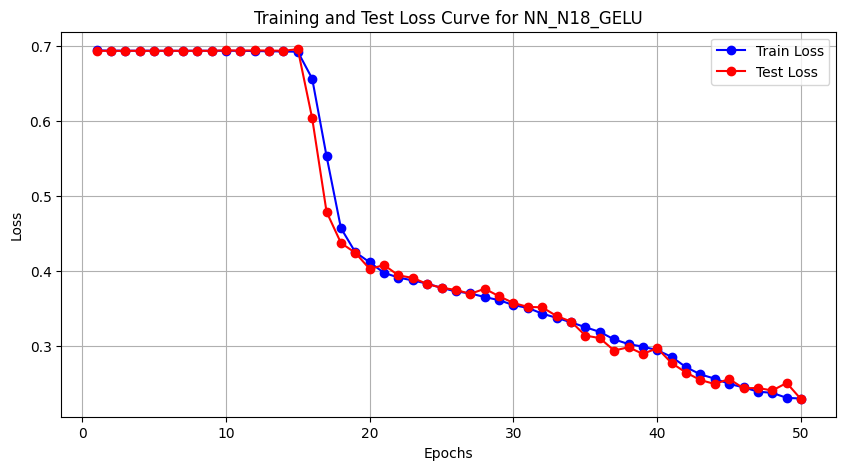

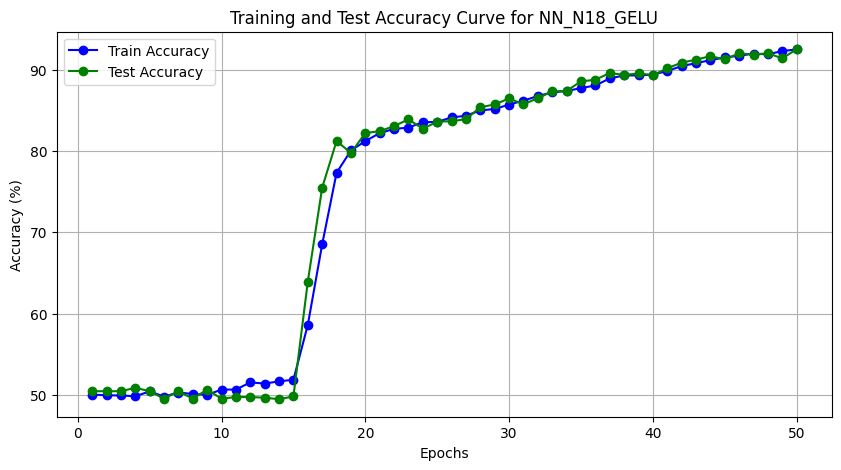

<ipython-input-24-67785c8c4fb8>:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(config['save_path']))


Final Test Accuracy for NN_N18_GELU: 92.53%
Confusion Matrix:
[[3327  240]
 [ 298 3335]]


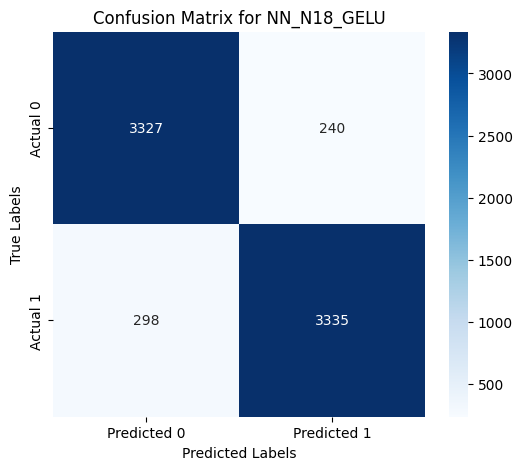

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9178    0.9327    0.9252      3567
         1.0     0.9329    0.9180    0.9254      3633

    accuracy                         0.9253      7200
   macro avg     0.9253    0.9253    0.9253      7200
weighted avg     0.9254    0.9253    0.9253      7200

{'NN_N24_GELU': {'model': BinaryClassifier(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=1, bias=True)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
), 'history': {'train_losses': [0.6934622465074

In [34]:


# Define model configurations
model_configs = [
    {
        'N': 18,
        'first_layer_size': 256,
        'activation': 'gelu',
        'epochs': 50,
        'model_name': 'NN_N18_GELU',
        'save_path': 'best_model_N18_GELU.pt'
    },
]



trained_models = train_and_evaluate_models(model_configs, device, trained_models)

print(trained_models)

Training NN_N18_RELU:   2%|▏         | 1/50 [00:02<02:14,  2.75s/it]

New best model saved with test loss: 0.6932
Epoch [1/50], Train Loss: 0.6934, Train Accuracy: 50.17%, Test Loss: 0.6932, Test Accuracy: 49.54%


Training NN_N18_RELU:   4%|▍         | 2/50 [00:05<02:11,  2.75s/it]

New best model saved with test loss: 0.6932


Training NN_N18_RELU:   6%|▌         | 3/50 [00:08<02:09,  2.76s/it]

New best model saved with test loss: 0.6931


Training NN_N18_RELU:  12%|█▏        | 6/50 [00:16<02:00,  2.74s/it]

New best model saved with test loss: 0.6931


Training NN_N18_RELU:  20%|██        | 10/50 [00:27<01:48,  2.71s/it]

New best model saved with test loss: 0.6930
Epoch [10/50], Train Loss: 0.6925, Train Accuracy: 51.78%, Test Loss: 0.6930, Test Accuracy: 50.61%


Training NN_N18_RELU:  22%|██▏       | 11/50 [00:30<01:46,  2.72s/it]

New best model saved with test loss: 0.5949


Training NN_N18_RELU:  24%|██▍       | 12/50 [00:32<01:43,  2.72s/it]

New best model saved with test loss: 0.4255


Training NN_N18_RELU:  26%|██▌       | 13/50 [00:35<01:40,  2.73s/it]

New best model saved with test loss: 0.3947


Training NN_N18_RELU:  28%|██▊       | 14/50 [00:38<01:37,  2.72s/it]

New best model saved with test loss: 0.3911


Training NN_N18_RELU:  30%|███       | 15/50 [00:40<01:35,  2.74s/it]

New best model saved with test loss: 0.3472


Training NN_N18_RELU:  32%|███▏      | 16/50 [00:43<01:33,  2.74s/it]

New best model saved with test loss: 0.3314


Training NN_N18_RELU:  34%|███▍      | 17/50 [00:46<01:30,  2.73s/it]

New best model saved with test loss: 0.3173


Training NN_N18_RELU:  36%|███▌      | 18/50 [00:49<01:26,  2.72s/it]

New best model saved with test loss: 0.2963


Training NN_N18_RELU:  38%|███▊      | 19/50 [00:51<01:24,  2.73s/it]

New best model saved with test loss: 0.2808


Training NN_N18_RELU:  40%|████      | 20/50 [00:54<01:21,  2.72s/it]

New best model saved with test loss: 0.2720
Epoch [20/50], Train Loss: 0.2656, Train Accuracy: 90.40%, Test Loss: 0.2720, Test Accuracy: 90.79%


Training NN_N18_RELU:  42%|████▏     | 21/50 [00:57<01:18,  2.71s/it]

New best model saved with test loss: 0.2637


Training NN_N18_RELU:  44%|████▍     | 22/50 [00:59<01:15,  2.70s/it]

New best model saved with test loss: 0.2606


Training NN_N18_RELU:  46%|████▌     | 23/50 [01:02<01:12,  2.70s/it]

New best model saved with test loss: 0.2599


Training NN_N18_RELU:  48%|████▊     | 24/50 [01:05<01:10,  2.71s/it]

New best model saved with test loss: 0.2573


Training NN_N18_RELU:  50%|█████     | 25/50 [01:08<01:07,  2.71s/it]

New best model saved with test loss: 0.2414


Training NN_N18_RELU:  52%|█████▏    | 26/50 [01:10<01:04,  2.70s/it]

New best model saved with test loss: 0.2278


Training NN_N18_RELU:  56%|█████▌    | 28/50 [01:16<00:59,  2.72s/it]

New best model saved with test loss: 0.2272


Training NN_N18_RELU:  60%|██████    | 30/50 [01:21<00:54,  2.72s/it]

New best model saved with test loss: 0.2171
Epoch [30/50], Train Loss: 0.1886, Train Accuracy: 94.15%, Test Loss: 0.2171, Test Accuracy: 93.24%


Training NN_N18_RELU:  66%|██████▌   | 33/50 [01:29<00:46,  2.71s/it]

New best model saved with test loss: 0.2144


Training NN_N18_RELU:  68%|██████▊   | 34/50 [01:32<00:43,  2.71s/it]

New best model saved with test loss: 0.1979


Training NN_N18_RELU:  78%|███████▊  | 39/50 [01:46<00:29,  2.70s/it]

New best model saved with test loss: 0.1947


Training NN_N18_RELU:  80%|████████  | 40/50 [01:48<00:26,  2.69s/it]

Epoch [40/50], Train Loss: 0.1549, Train Accuracy: 95.50%, Test Loss: 0.1958, Test Accuracy: 94.39%


Training NN_N18_RELU:  84%|████████▍ | 42/50 [01:54<00:21,  2.69s/it]

New best model saved with test loss: 0.1880


Training NN_N18_RELU: 100%|██████████| 50/50 [02:15<00:00,  2.71s/it]

Epoch [50/50], Train Loss: 0.1363, Train Accuracy: 96.12%, Test Loss: 0.2014, Test Accuracy: 94.12%


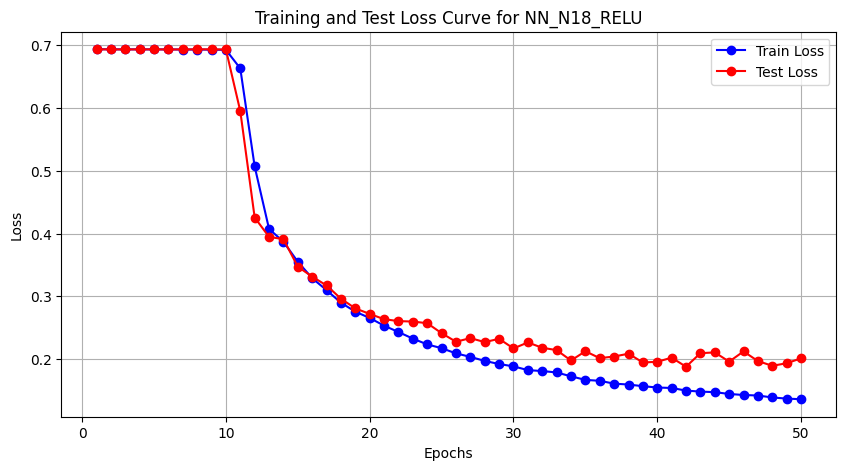

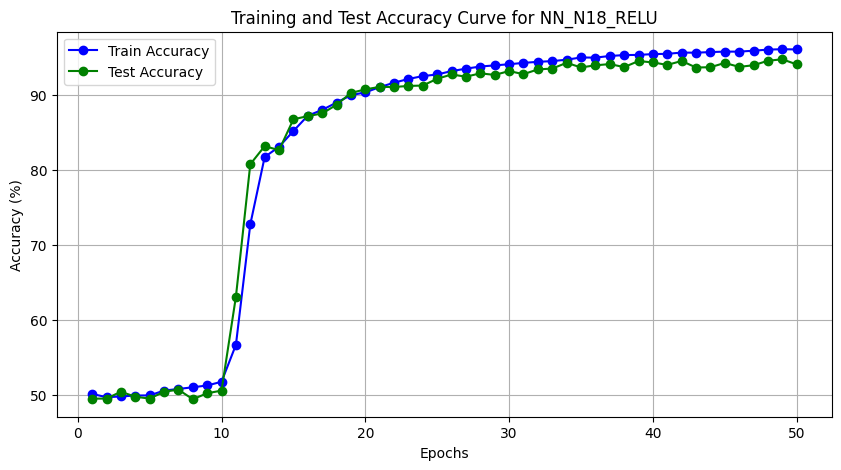

<ipython-input-24-67785c8c4fb8>:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(config['save_path']))


Final Test Accuracy for NN_N18_RELU: 94.58%
Confusion Matrix:
[[3378  189]
 [ 201 3432]]


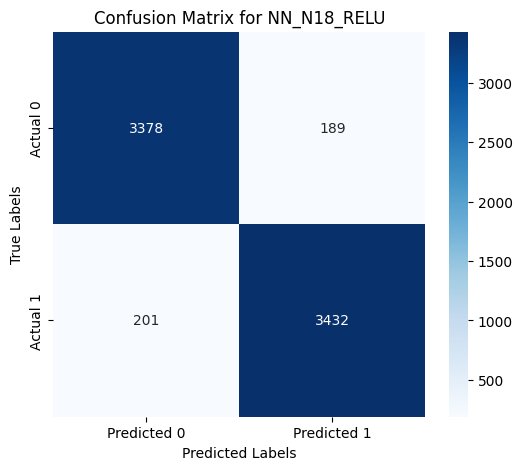

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9438    0.9470    0.9454      3567
         1.0     0.9478    0.9447    0.9462      3633

    accuracy                         0.9458      7200
   macro avg     0.9458    0.9458    0.9458      7200
weighted avg     0.9458    0.9458    0.9458      7200

{'NN_N24_GELU': {'model': BinaryClassifier(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=1, bias=True)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
), 'history': {'train_losses': [0.6934867490828

In [32]:
model_configs = [{
        'N': 18,
        'first_layer_size': 256,
        'activation': 'relu',
        'epochs': 50,
        'model_name': 'NN_N18_RELU',
        'save_path': 'best_model_N18_RELU.pt'
    }]

trained_models = train_and_evaluate_models(model_configs, device, trained_models)

print(trained_models)


Training NN_N24_GELU:   1%|          | 1/100 [00:03<06:06,  3.70s/it]

New best model saved with test loss: 0.6932
Epoch [1/100], Train Loss: 0.6935, Train Accuracy: 49.86%, Test Loss: 0.6932, Test Accuracy: 49.39%


Training NN_N24_GELU:   3%|▎         | 3/100 [00:11<05:57,  3.69s/it]

New best model saved with test loss: 0.6931


Training NN_N24_GELU:   4%|▍         | 4/100 [00:14<05:57,  3.72s/it]

New best model saved with test loss: 0.6931


Training NN_N24_GELU:   9%|▉         | 9/100 [00:33<05:33,  3.66s/it]

New best model saved with test loss: 0.6931


Training NN_N24_GELU:  10%|█         | 10/100 [00:36<05:29,  3.66s/it]

Epoch [10/100], Train Loss: 0.6932, Train Accuracy: 49.73%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  16%|█▌        | 16/100 [00:58<05:05,  3.63s/it]

New best model saved with test loss: 0.6931


Training NN_N24_GELU:  20%|██        | 20/100 [01:13<04:52,  3.65s/it]

New best model saved with test loss: 0.6931
Epoch [20/100], Train Loss: 0.6932, Train Accuracy: 49.72%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  30%|███       | 30/100 [01:49<04:13,  3.63s/it]

Epoch [30/100], Train Loss: 0.6932, Train Accuracy: 49.86%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  40%|████      | 40/100 [02:26<03:39,  3.65s/it]

Epoch [40/100], Train Loss: 0.6932, Train Accuracy: 50.32%, Test Loss: 0.6933, Test Accuracy: 49.39%


Training NN_N24_GELU:  50%|█████     | 50/100 [03:03<03:04,  3.69s/it]

Epoch [50/100], Train Loss: 0.6932, Train Accuracy: 49.96%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  60%|██████    | 60/100 [03:39<02:24,  3.62s/it]

Epoch [60/100], Train Loss: 0.6932, Train Accuracy: 50.27%, Test Loss: 0.6932, Test Accuracy: 49.39%


Training NN_N24_GELU:  70%|███████   | 70/100 [04:16<01:49,  3.65s/it]

Epoch [70/100], Train Loss: 0.6932, Train Accuracy: 50.10%, Test Loss: 0.6933, Test Accuracy: 49.39%


Training NN_N24_GELU:  80%|████████  | 80/100 [04:52<01:12,  3.61s/it]

Epoch [80/100], Train Loss: 0.6932, Train Accuracy: 49.67%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  90%|█████████ | 90/100 [05:28<00:35,  3.58s/it]

Epoch [90/100], Train Loss: 0.6932, Train Accuracy: 49.93%, Test Loss: 0.6931, Test Accuracy: 50.61%


Training NN_N24_GELU:  92%|█████████▏| 92/100 [05:35<00:28,  3.58s/it]

New best model saved with test loss: 0.6931


Training NN_N24_GELU: 100%|██████████| 100/100 [06:04<00:00,  3.64s/it]

Epoch [100/100], Train Loss: 0.6932, Train Accuracy: 50.07%, Test Loss: 0.6932, Test Accuracy: 49.39%


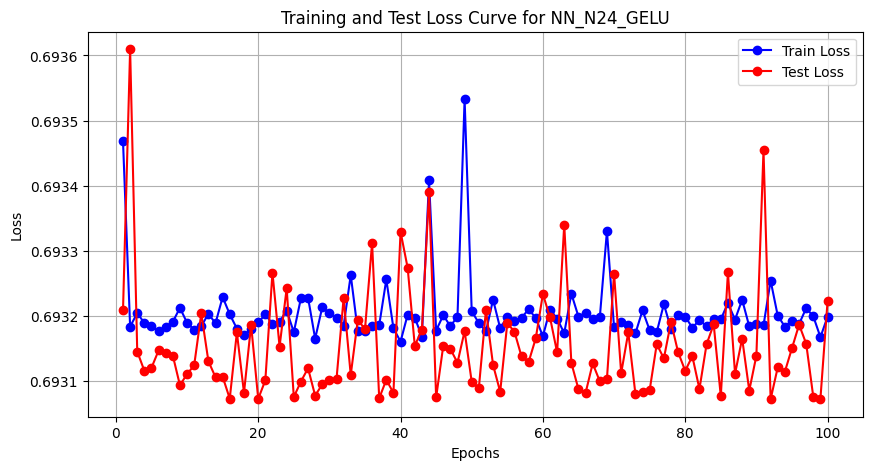

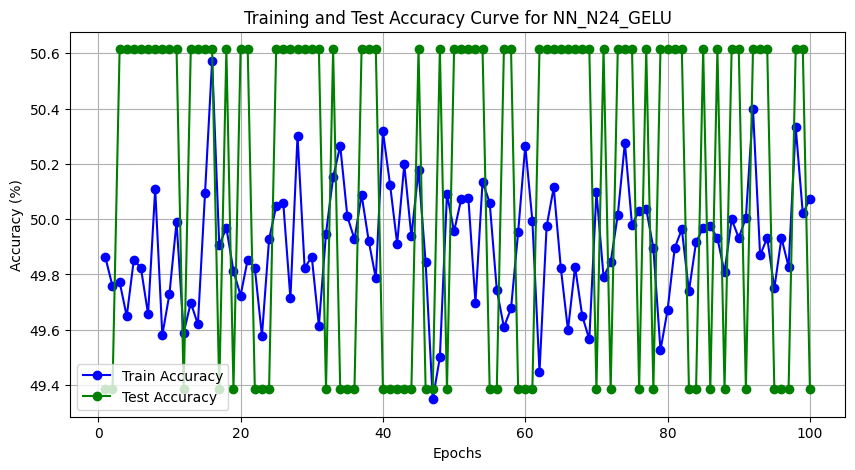

<ipython-input-24-67785c8c4fb8>:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(config['save_path']))


Final Test Accuracy for NN_N24_GELU: 50.61%
Confusion Matrix:
[[   0 4741]
 [   0 4859]]


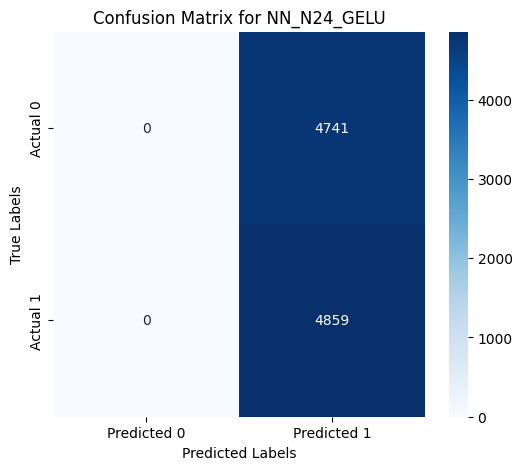

Classification Report:
              precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000      4741
         1.0     0.5061    1.0000    0.6721      4859

    accuracy                         0.5061      9600
   macro avg     0.2531    0.5000    0.3361      9600
weighted avg     0.2562    0.5061    0.3402      9600

{'NN_N24_GELU': {'model': BinaryClassifier(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (bn1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=1, bias=True)
  (activation): GELU(approximate='none')
  (sigmoid): Sigmoid()
), 'history': {'train_losses': [0.6934682301680

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [38]:

model_configs = [    {
        'N': 24,
        'first_layer_size': 512,
        'activation': 'gelu',
        'epochs': 100,
        'model_name': 'NN_N24_GELU',
        'save_path': 'best_model_N24_GELU.pt'
    }
]
trained_models = train_and_evaluate_models(model_configs, device, trained_models)
print(trained_models)

# Visualise weights


Weight Distributions for NN_N24_GELU:


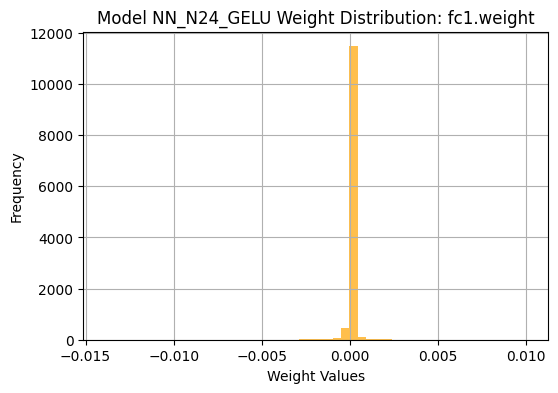

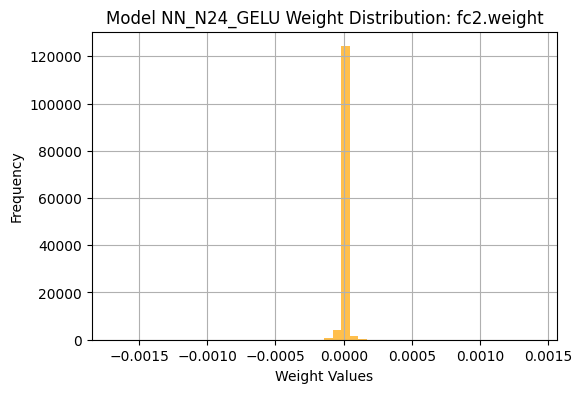

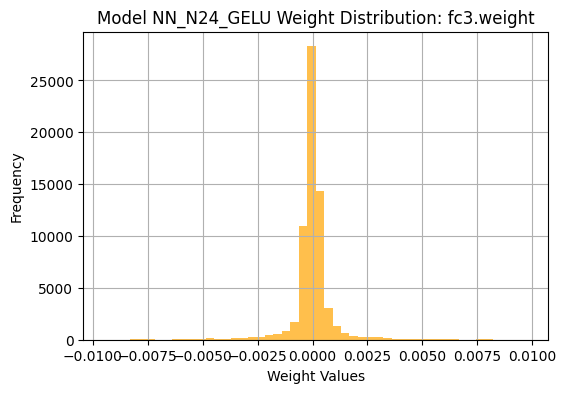

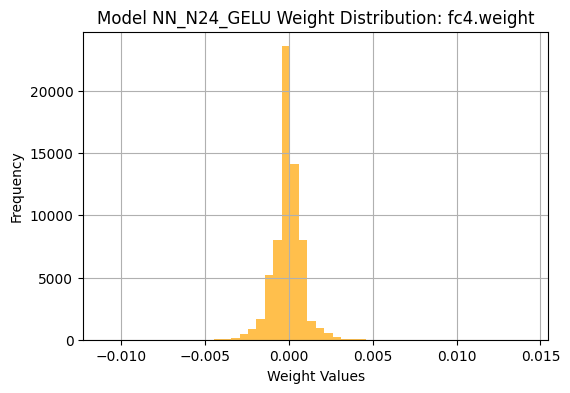

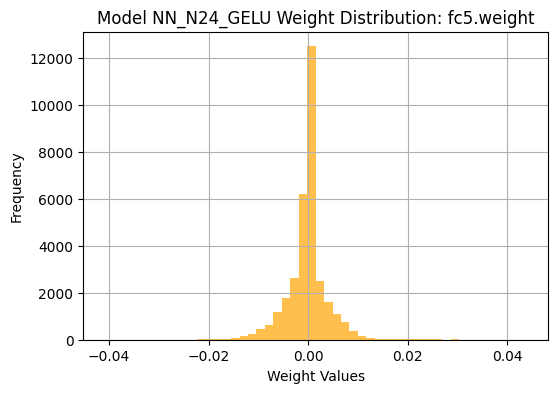

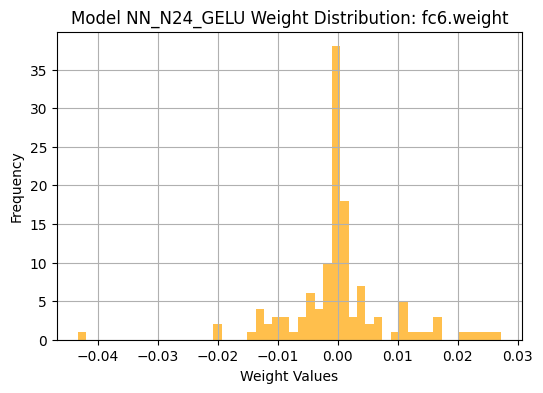


Weight Distributions for NN_N18_GELU:


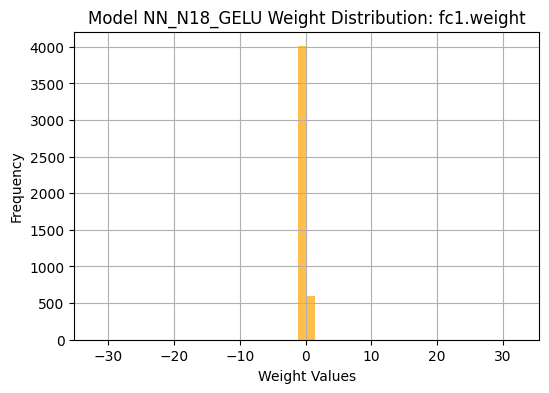

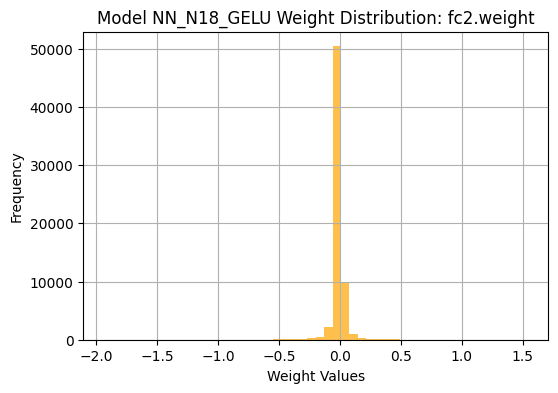

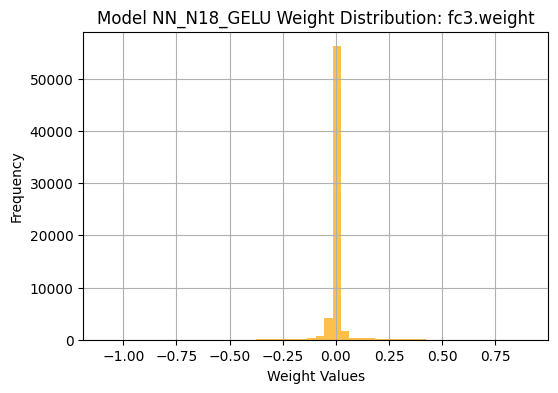

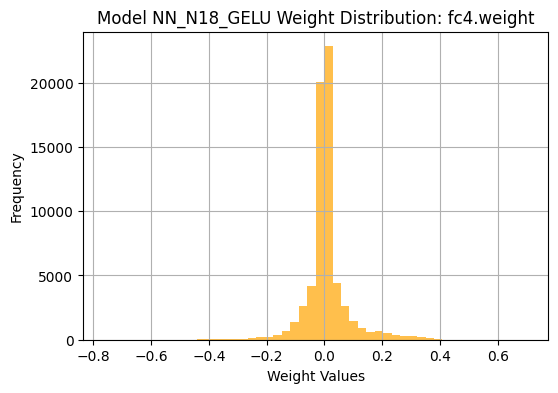

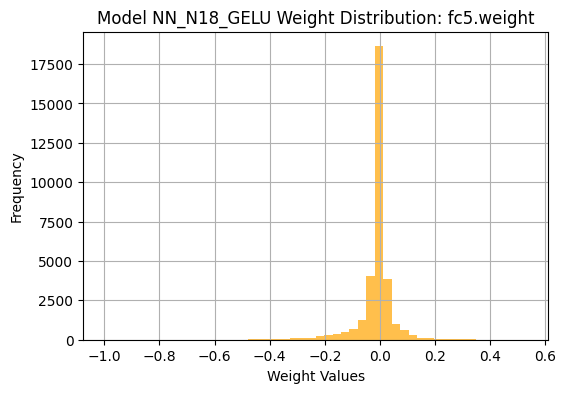

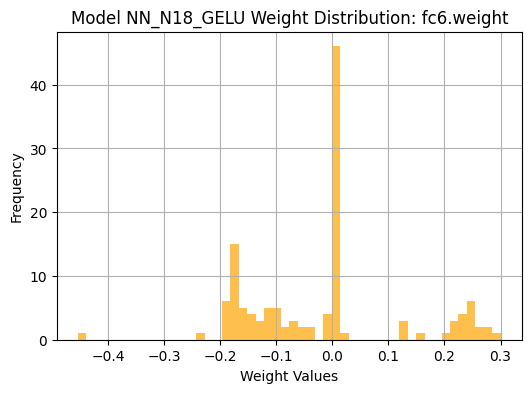


Weight Distributions for NN_N18_RELU:


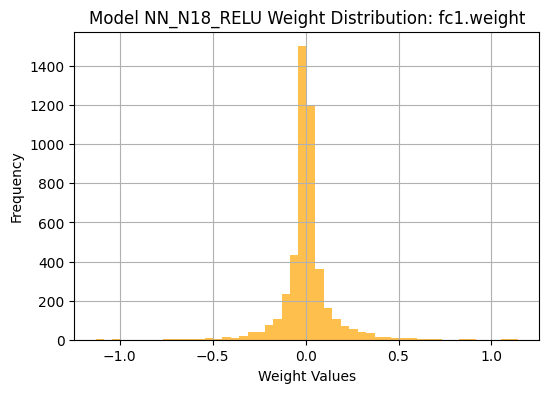

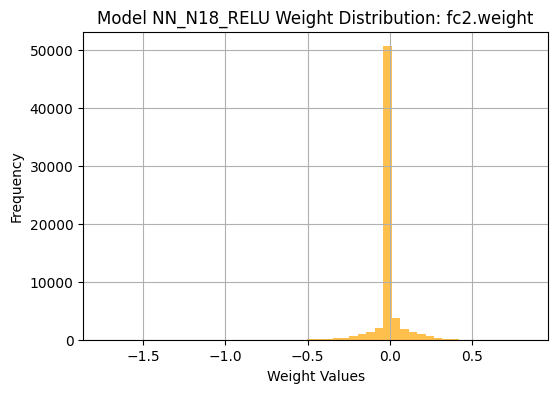

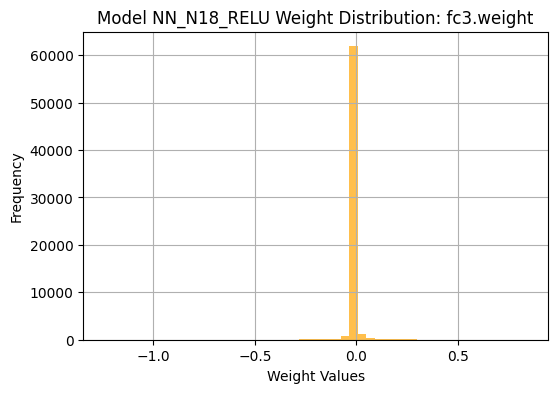

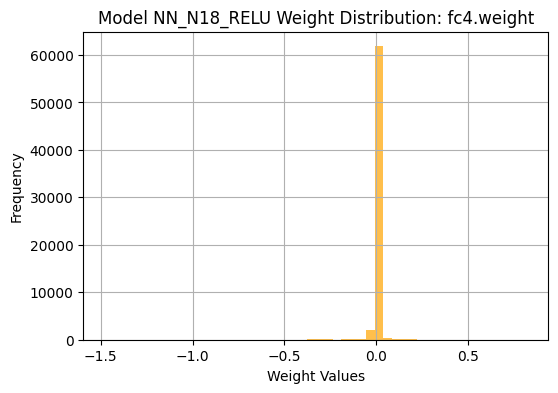

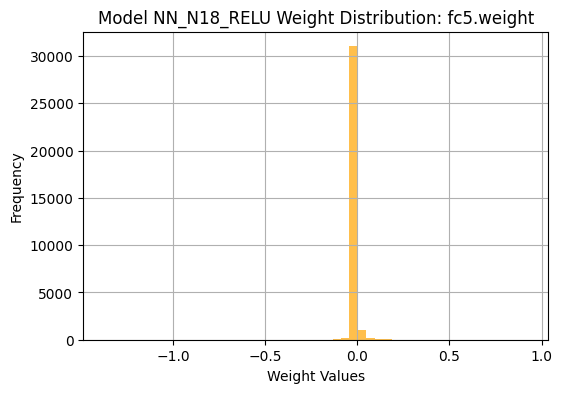

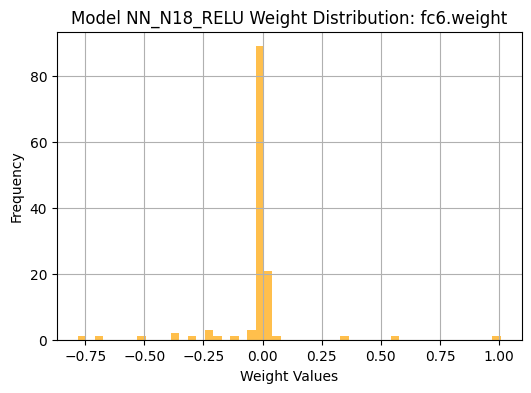

In [39]:

for model_name, data in trained_models.items():
    print(f"\nWeight Distributions for {model_name}:")
    plot_weight_distributions(data['model'], layer_names=['fc1', 'fc2', 'fc3', 'fc4', 'fc5', 'fc6'], display_name=model_name)



Performing Perturbation Analysis for NN_N24_GELU...


Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1668.92it/s]


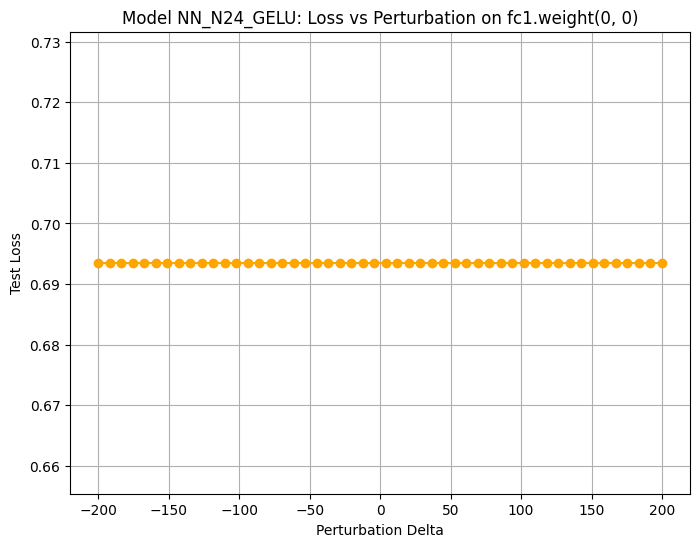

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1667.98it/s]


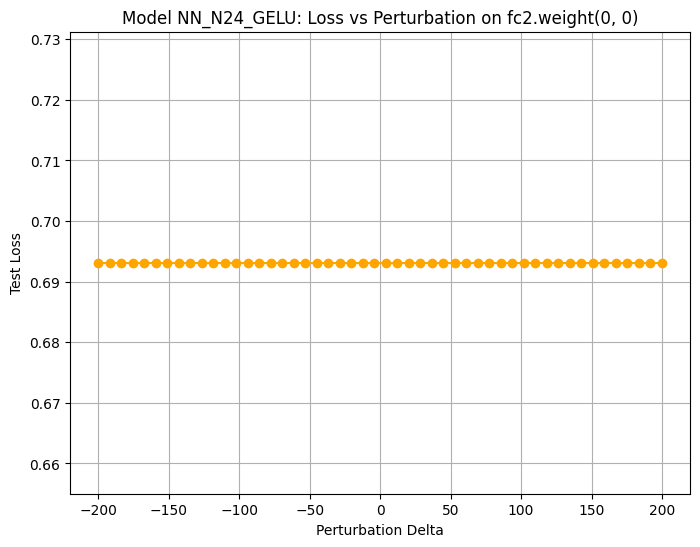

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1707.19it/s]


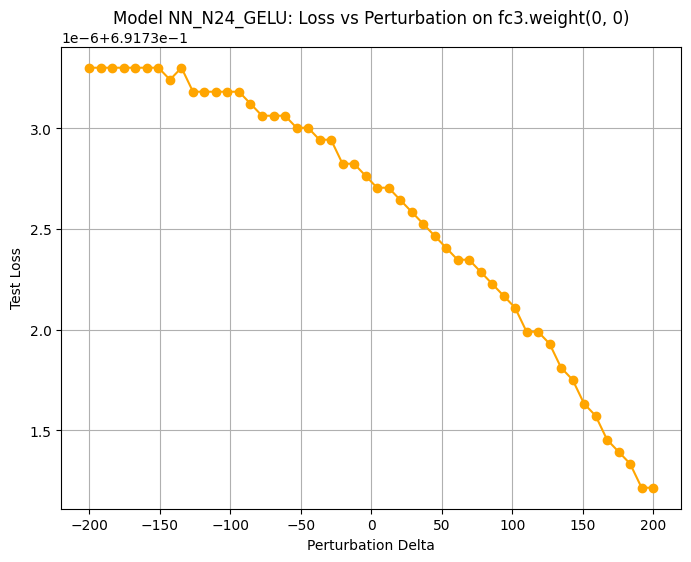

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1738.92it/s]


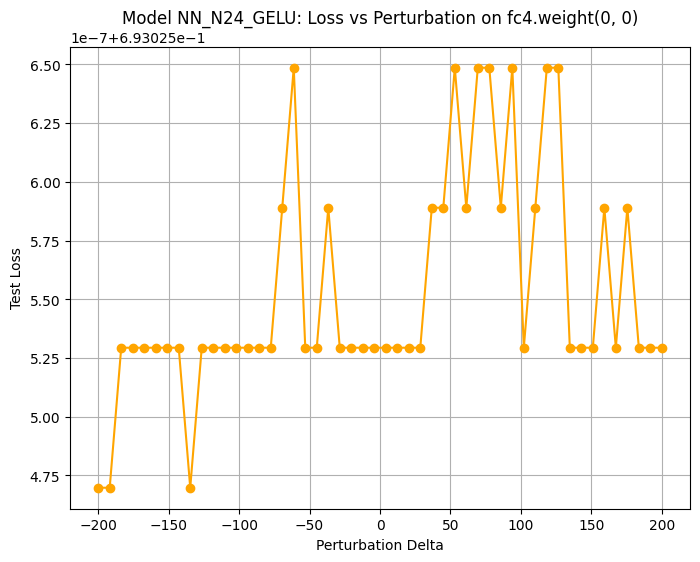

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1672.48it/s]


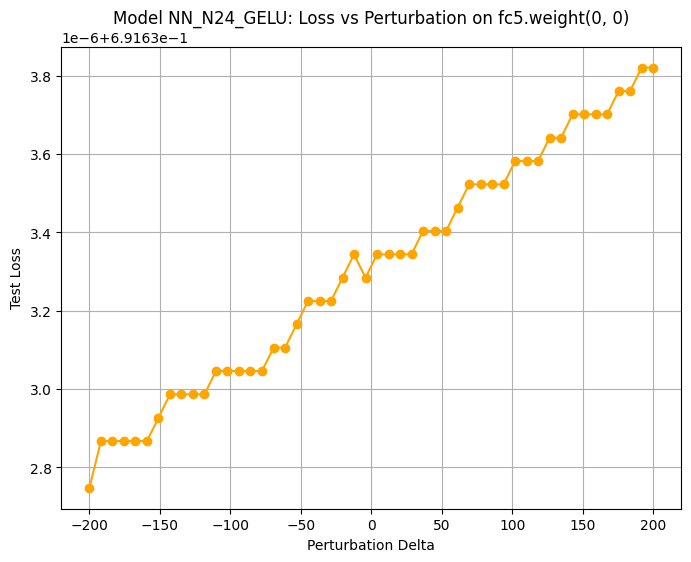

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1679.66it/s]


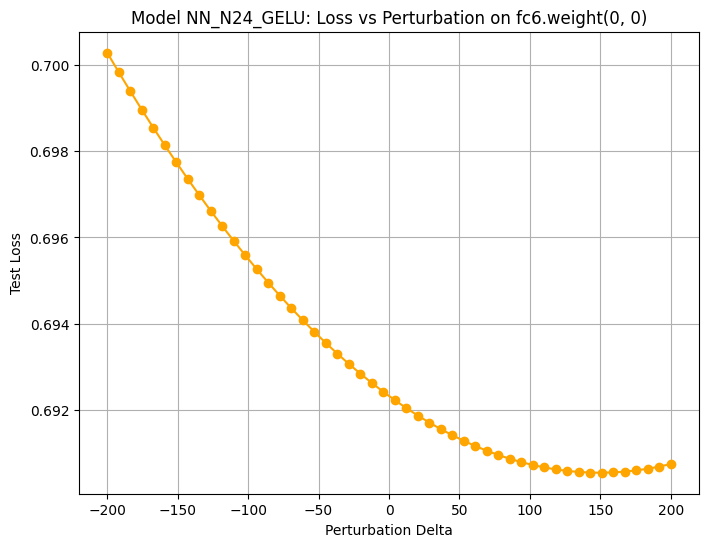

Delta1: 100%|██████████| 400/400 [01:35<00:00,  4.20it/s]


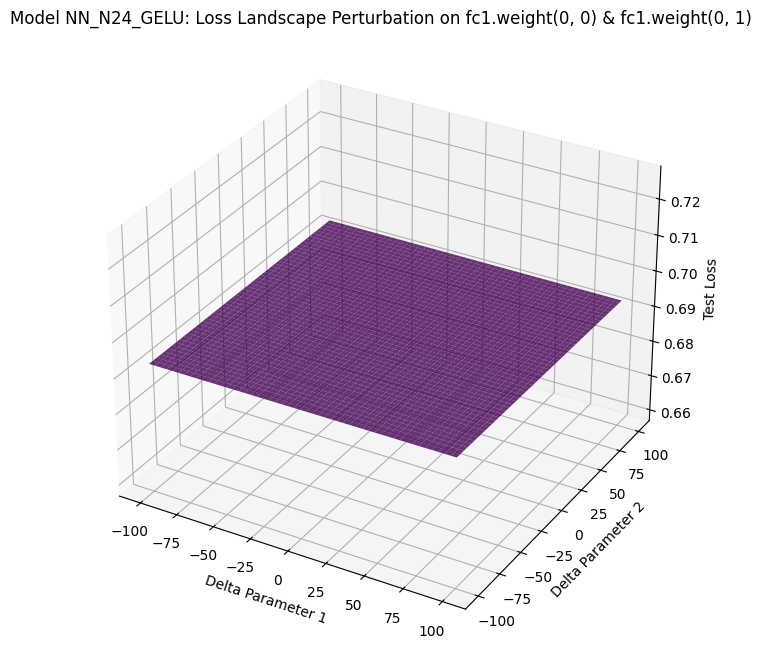


Performing Perturbation Analysis for NN_N18_GELU...


Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1678.85it/s]


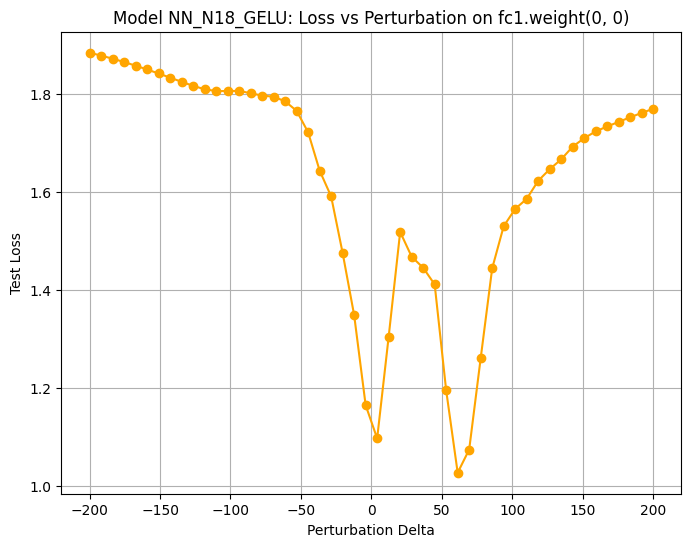

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1726.29it/s]


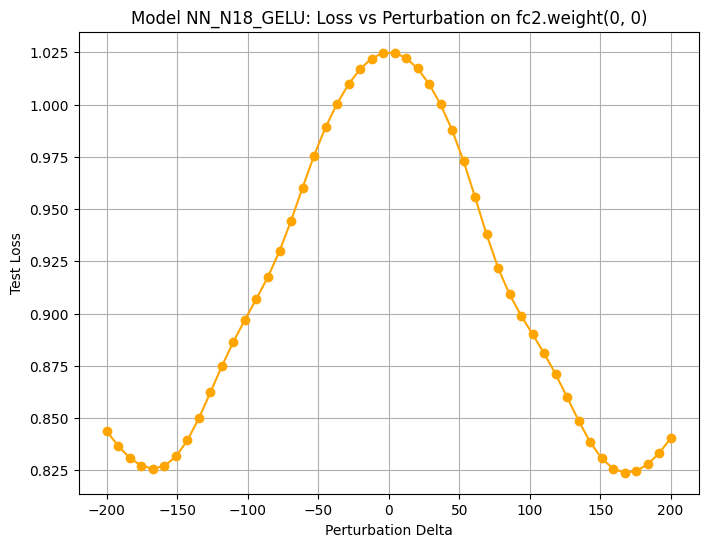

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1733.04it/s]


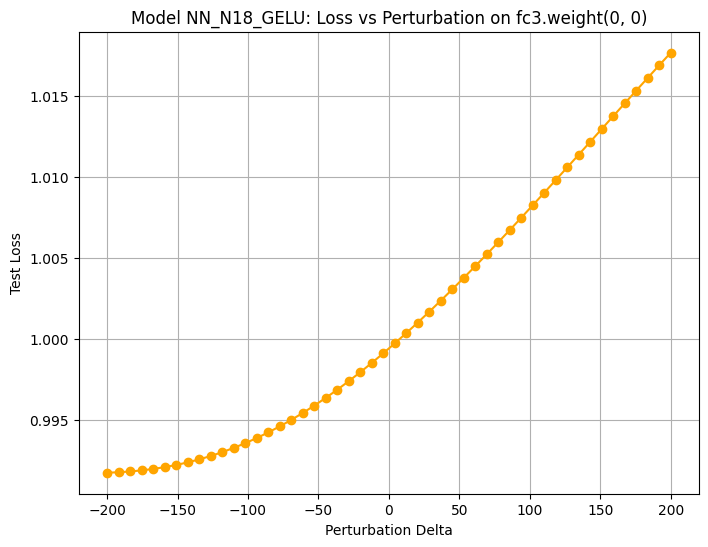

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1780.57it/s]


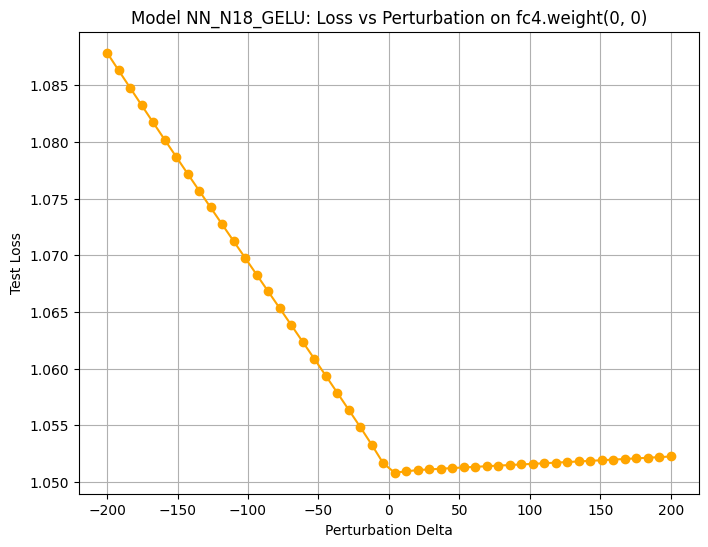

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1735.68it/s]


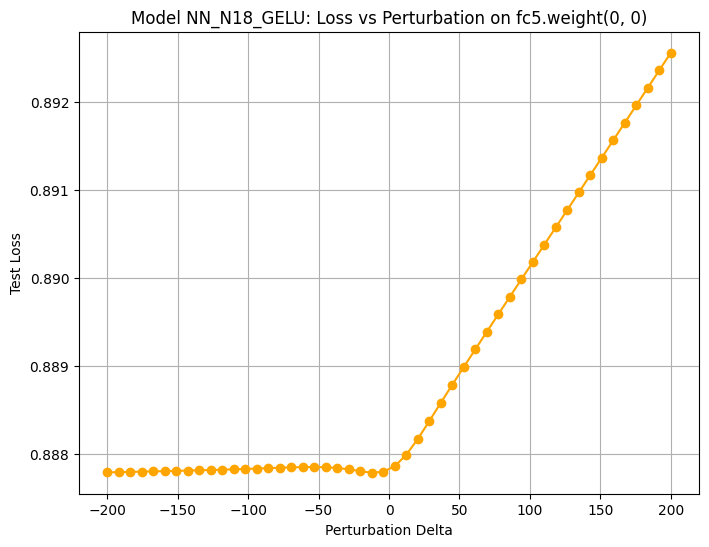

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1739.90it/s]


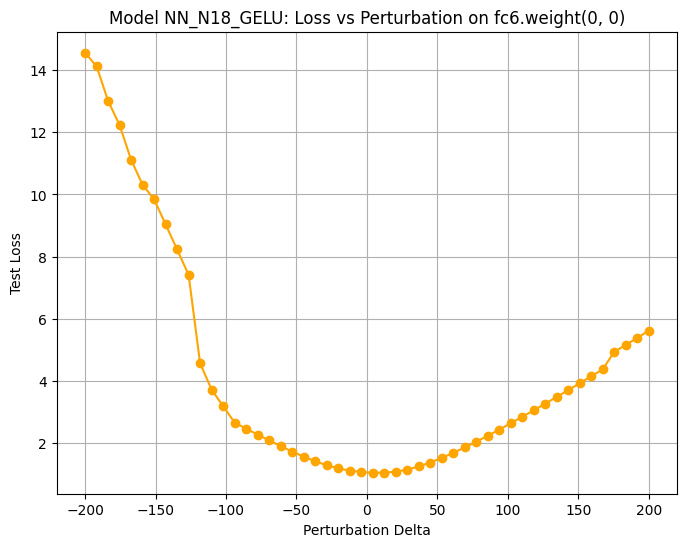

Delta1: 100%|██████████| 200/200 [00:23<00:00,  8.38it/s]


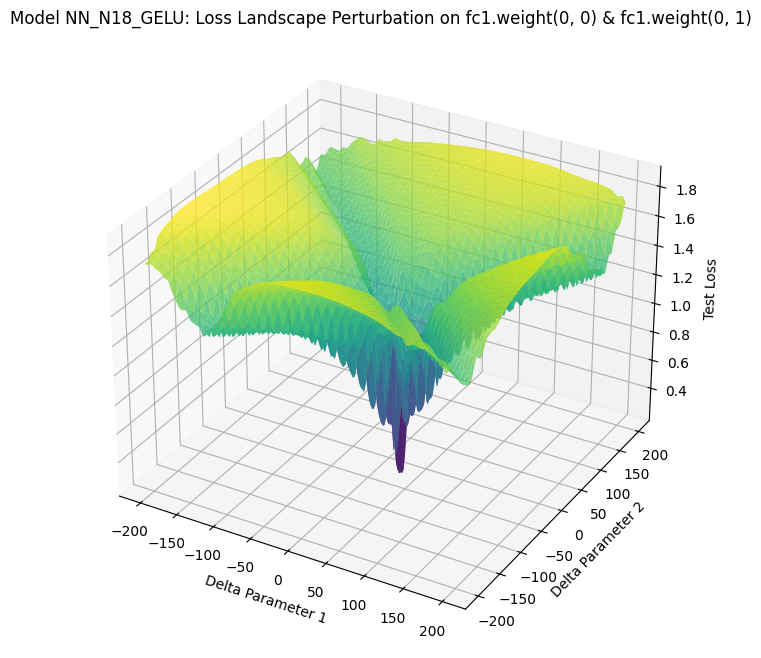


Performing Perturbation Analysis for NN_N18_RELU...


Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1571.55it/s]


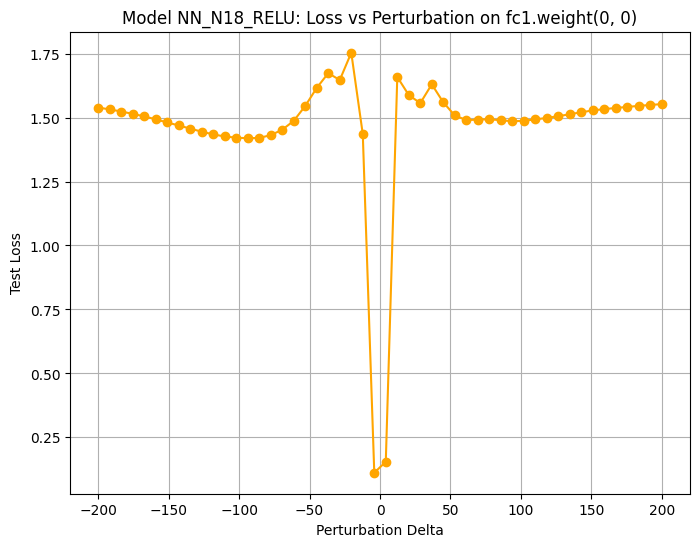

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1706.10it/s]


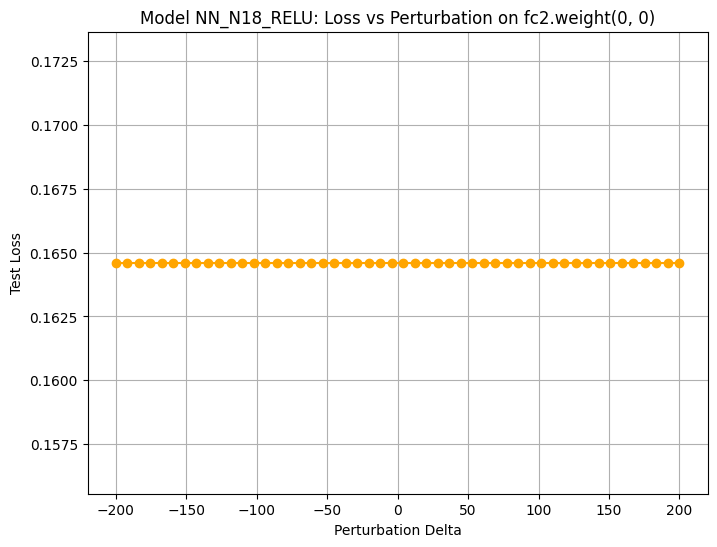

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1652.19it/s]


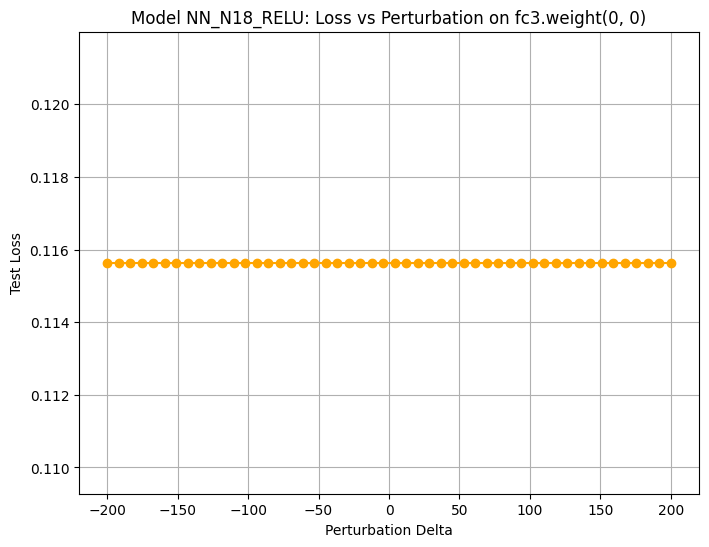

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1729.90it/s]


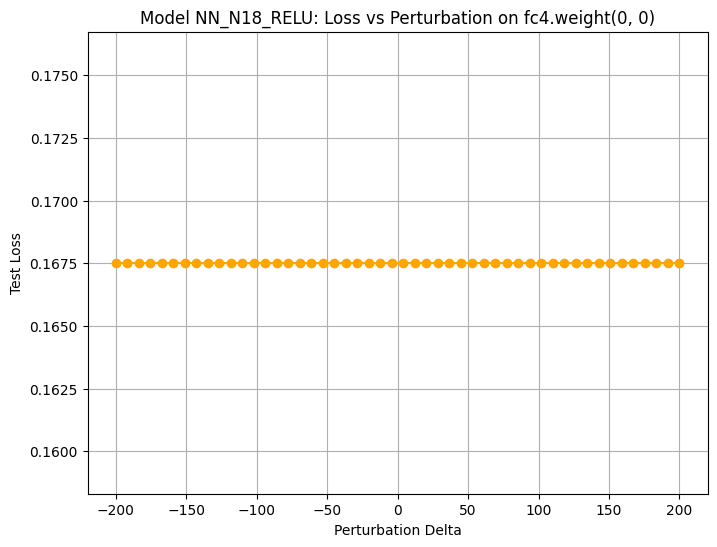

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1636.80it/s]


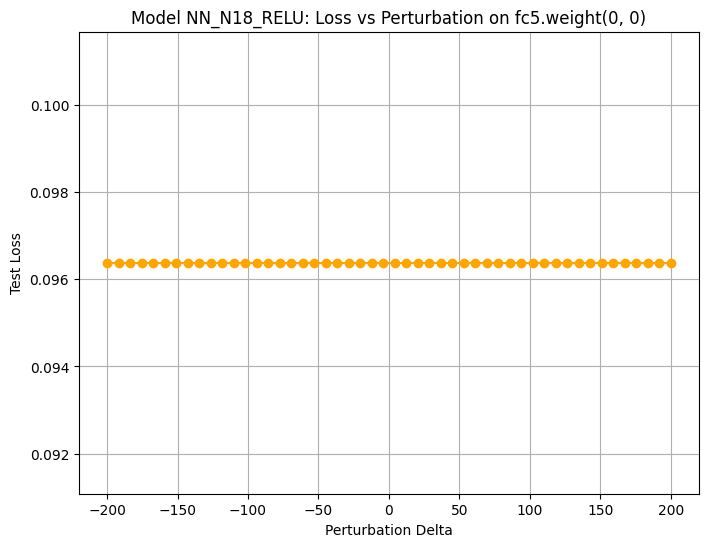

Perturbations: 100%|██████████| 50/50 [00:00<00:00, 1689.17it/s]


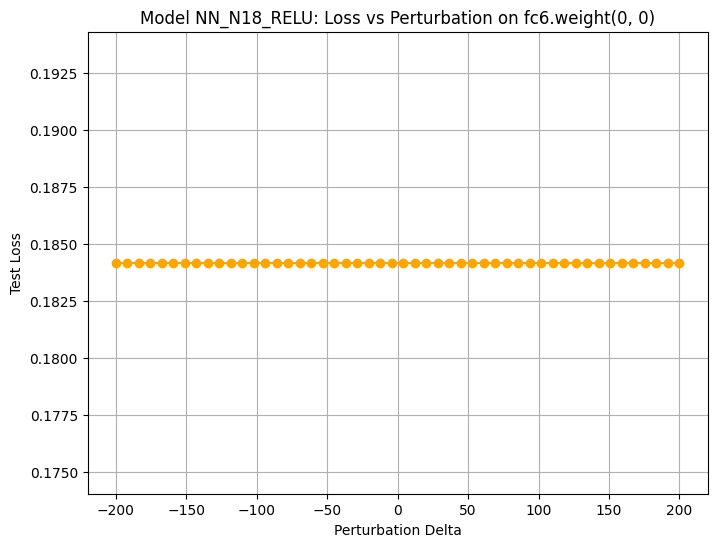

Delta1: 100%|██████████| 200/200 [00:24<00:00,  8.32it/s]


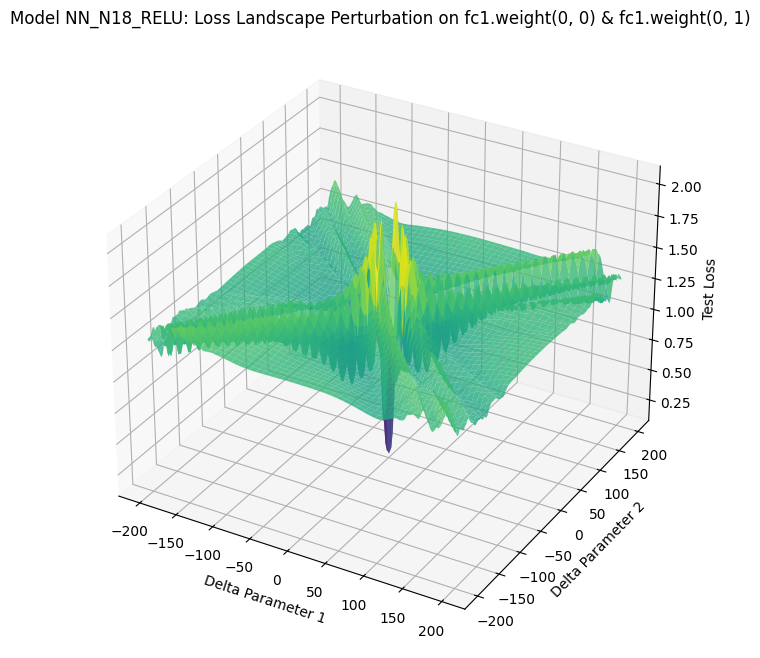

In [40]:
# Define perturbation range
delta_range_1d = np.linspace(-200.0, 200, 50)
delta_range_2d = np.linspace(-200, 200, 200)
delta_range_2d_granular = np.linspace(-100, 100, 400)

criterion = nn.BCELoss()


# Perform perturbation analysis for each model
for model_name, data in trained_models.items():
    model = data['model']
    train_loader = data['train_loader']  # Retrieve the correct train_loader for the model

    print(f"\nPerforming Perturbation Analysis for {model_name}...")

    # Example 1D Perturbation on first weight of fc1
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc1',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device
                                 , subset_size=250)

    # Example 1D Perturbation on first weight of fc2
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc2',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device, subset_size=250)


    # Example 1D Perturbation on first weight of fc3
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc3',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device, subset_size=250)

    # Example 1D Perturbation on first weight of fc4
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc4',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device, subset_size=250)


    # Example 1D Perturbation on first weight of fc5
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc5',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device, subset_size=250)


    # Example 1D Perturbation on first weight of fc6
    visualise_loss_perturbation(model, model_name, train_loader, criterion,
                                 layer_name='fc6',
                                 param_name='weight',
                                 param_idx=(0, 0),
                                 delta_range=delta_range_1d,
                                 device=device, subset_size=250)

    if model_name == "NN_N24_GELU":
        # Example 2D Perturbation on first two weights of fc3
        visualise_loss_perturbation_2d(model, model_name, train_loader, criterion,
                                        layer_name='fc1',
                                        param_name='weight',
                                        param1_idx=(0, 0),
                                        param2_idx=(0, 1),
                                        delta_range=delta_range_2d_granular,
                                        device=device, subset_size=250)
    else:
        # Example 2D Perturbation on first two weights of fc3
        visualise_loss_perturbation_2d(model, model_name, train_loader, criterion,
                                        layer_name='fc1',
                                        param_name='weight',
                                        param1_idx=(0, 0),
                                        param2_idx=(0, 1),
                                        delta_range=delta_range_2d,
                                        device=device, subset_size=250)

